# Q&A GOOGLE QUEST PROJECT | GROUP 2
**Text Analytics | Prof Evan**

**Group Members:** Tram Ngoc Le, Yanqi Shi, Annuo Qian, Xuejun Shen, Bing Yue Zheng

## Part 2: Q&A Category Classification

In Q&A Type Classification part, Google questions are classified into **10 types** and Google answers are classified into **4 types**, by application of supervised machine learning technique along with text analytics. 

Since the test data set provided by Kaggle do not provide the probabilities scores of each types, we could not generate the labels for the target. In this case, we will parition our pre-processed train data set with labels into 

Our target variable for question is **question_target_mixed** and our target variable for answer is **answer_target_mixed**

We assigned the labels by using the highest probabilities score from each question type variables. If the observation contains more than one highest score, we label that obersvation as mixed type.


The process of the methodology implementation are set up as below:

- **Step 1. Preliminary steps**  - Set up packages | Load Text | Initial exploratory | Text Preprocessing
- **Step 2. Text Preprocessing** - Stopwords Removal, Stemming, Lowercase, ...etc
- **Step 3. Feature Engineering**  - TFIDF features
- **Step 4. Oversampling** - Handle unbalanced class problem with TFIDF features
- **Step 5. Model Building** - SVM | Naive Bayes |
- **Step 6. Model Selection** - Model Comparison & Selection - Metrics: Accuracy rate on training data
- **Step 7. Model Evaluation** - Metrics: Accuracy, F1 Score, Precision Score, Recall Score
- **Step 8. TensorFlow | LSTM** - Feature Encoder | Fit Model | Evaluate Model
- **Step 9. Conclusion**
- **Appendix** - Evaluate other features + models that were tried before the best features and best models are created 
- **Reference**
**Note**: *Questions and Answers are categorized seperately*
# ___
## Step 1: Preliminary Steps

### Setup required packages/libraries 

In [2]:
import pandas as pd
import numpy as np
import nltk
import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import seaborn as sns
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

### Load Data & Initial data exploring

In [17]:
# Load preprocess data
df = pd.read_csv("type_train.csv")

### ` Question `

In [18]:
# Saving QUESTION info into different dataframe
df_question = df[['qa_id', 'question_title','question_body','question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling','question_target_mix',
       'question_target_detailed' ]]
df_question.head()

,qa_id,question_title,question_body,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_target_mix,question_target_detailed
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,0.000000,0.0,question_type_instructions,question_type_instructions
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,0.666667,0.666667,0.0,0.333333,0.0,0.0,0.000000,0.333333,0.0,question_type_mixed,"question_type_choice, question_type_compare"
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.333333,0.333333,0.0,question_type_instructions,question_type_instructions
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",1.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,question_type_choice,question_type_choice
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,1.000000,0.0,question_type_mixed,"question_type_instructions, question_type_reas..."


Observation Distribution of 10  Questions Types (%):
question_type_instructions          36.34
question_type_mixed                 23.49
question_type_reason_explanation    19.10
question_type_choice                11.71
question_type_entity                 3.08
question_type_procedure              2.83
question_type_definition             1.56
question_type_compare                1.53
question_type_consequence            0.33
question_type_spelling               0.03
Name: question_target_mix, dtype: float64


Text(0.5, 1.0, 'Observations Distribution of Classes')

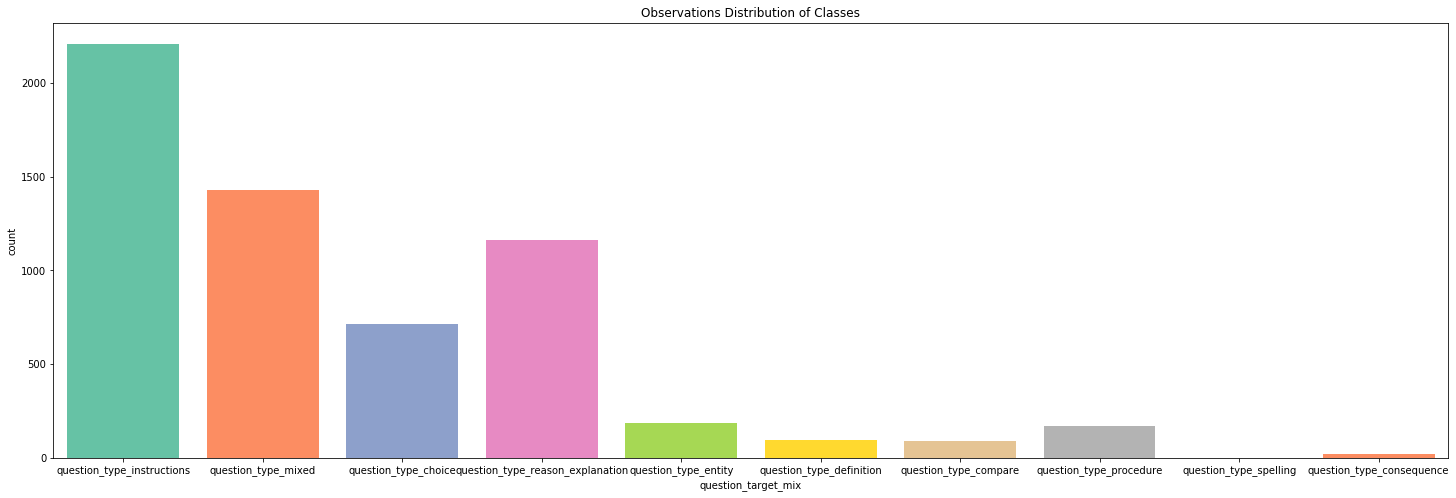

In [19]:
# See distribution of observations between target
print("Observation Distribution of", len(df_question.question_target_mix.unique()) ," Questions Types (%):")
print(round((df_question.question_target_mix.value_counts()/len(df_question.question_target_mix))*100,2))
# Create a bar chat of distribution of observations for each class
plt.figure(figsize=(25,8))
sns.countplot(x="question_target_mix", data=df_question, palette="Set2", saturation = 1).set_title("Observations Distribution of Classes")

In [20]:
# create question id
df_question['question_id']=df_question['question_target_mix'].factorize()[0]
question_id_df = df_question[['question_target_mix','question_id']].drop_duplicates().sort_values('question_id')
question_to_id = dict(question_id_df.values)
id_to_question = dict(question_id_df[['question_id','question_target_mix']].values)
df_question.head()
id_to_question

C:\Users\Jennie\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


{0: 'question_type_instructions',
 1: 'question_type_mixed',
 2: 'question_type_choice',
 3: 'question_type_reason_explanation',
 4: 'question_type_entity',
 5: 'question_type_definition',
 6: 'question_type_compare',
 7: 'question_type_procedure',
 8: 'question_type_spelling',
 9: 'question_type_consequence'}

In [21]:
df_question.head()

,qa_id,question_title,question_body,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_target_mix,question_target_detailed,question_id
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,0.000000,0.0,question_type_instructions,question_type_instructions,0
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,0.666667,0.666667,0.0,0.333333,0.0,0.0,0.000000,0.333333,0.0,question_type_mixed,"question_type_choice, question_type_compare",1
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.333333,0.333333,0.0,question_type_instructions,question_type_instructions,0
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",1.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,question_type_choice,question_type_choice,2
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,1.000000,0.0,question_type_mixed,"question_type_instructions, question_type_reas...",1


### `Answer`

In [22]:
# Saving ANSWER info into different dataframe
df_answer = df[['answer', 'answer_type_instructions',
       'answer_type_procedure', 'answer_type_reason_explanation','answer_target_mix',
       'answer_target_detailed' ]]
df_answer.head()

,answer,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_target_mix,answer_target_detailed
0,"I just got extension tubes, so here's the skin...",1.0,0.000000,0.000000,answer_type_instructions,answer_type_instructions
1,It might be helpful to look into the definitio...,0.0,0.000000,0.666667,answer_type_reason_explanation,answer_type_reason_explanation
2,Do you even need grooves? We make several pro...,0.0,0.333333,1.000000,answer_type_reason_explanation,answer_type_reason_explanation
3,"Sending an ""affidavit"" it is a dispute between...",0.0,0.000000,1.000000,answer_type_reason_explanation,answer_type_reason_explanation
4,Check out Image Trace in Adobe Illustrator. \n...,1.0,0.000000,1.000000,answer_type_mixed,"answer_type_instructions, answer_type_reason_e..."


Observation Distribution of 4  Answer Types (%):
answer_type_reason_explanation    40.27
answer_type_instructions          37.87
answer_type_mixed                 18.77
answer_type_procedure              3.09
Name: answer_target_mix, dtype: float64


Text(0.5, 1.0, 'Distribution of Classes')

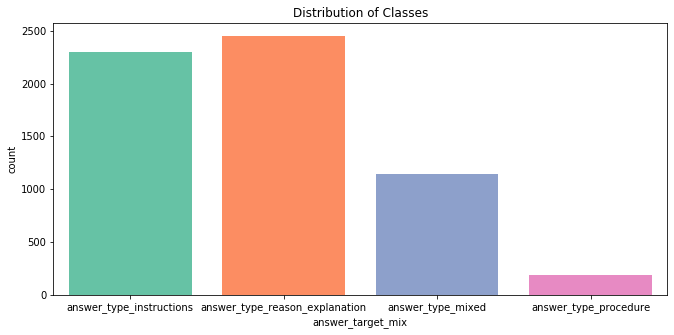

In [23]:
# See distribution of observations between target
print("Observation Distribution of", len(df_answer.answer_target_mix.unique()) ," Answer Types (%):")
print(round((df_answer.answer_target_mix.value_counts()/len(df_answer.answer_target_mix))*100,2))
# Create a bar chat of distribution of observations for each class
plt.figure(figsize=(11,5))
sns.countplot(x="answer_target_mix", data=df_answer, palette="Set2", saturation = 1).set_title("Distribution of Classes")

In [24]:
df_answer['answer_id']=df_answer['answer_target_mix'].factorize()[0]
answer_id_df = df_answer[['answer_target_mix','answer_id']].drop_duplicates().sort_values('answer_id')
answer_to_id = dict(answer_id_df.values)
id_to_answer = dict(answer_id_df[['answer_id','answer_target_mix']].values)
df_answer.head()
id_to_answer

C:\Users\Jennie\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


{0: 'answer_type_instructions',
 1: 'answer_type_reason_explanation',
 2: 'answer_type_mixed',
 3: 'answer_type_procedure'}

In [25]:
df_answer.head()

,answer,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_target_mix,answer_target_detailed,answer_id
0,"I just got extension tubes, so here's the skin...",1.0,0.000000,0.000000,answer_type_instructions,answer_type_instructions,0
1,It might be helpful to look into the definitio...,0.0,0.000000,0.666667,answer_type_reason_explanation,answer_type_reason_explanation,1
2,Do you even need grooves? We make several pro...,0.0,0.333333,1.000000,answer_type_reason_explanation,answer_type_reason_explanation,1
3,"Sending an ""affidavit"" it is a dispute between...",0.0,0.000000,1.000000,answer_type_reason_explanation,answer_type_reason_explanation,1
4,Check out Image Trace in Adobe Illustrator. \n...,1.0,0.000000,1.000000,answer_type_mixed,"answer_type_instructions, answer_type_reason_e...",2


- Preprocessing Text

## Step 2: Text Preprocessing

- Remove Stopwords
- Stemming
- Lowercase
- Remove some non-alphabet label

In [26]:
from nltk.corpus import stopwords
# Define preprocessing function 
def preprocessing_text(text):
    # Stopwords Removal
    my_stopwords = stopwords.words('english')
    # Stemming
    wnl = nltk.WordNetLemmatizer()
    tag_remove = re.compile(r'<[^>]+>')
    text = tag_remove.sub('',text)
    # tokenization
    tokens = nltk.word_tokenize(text)
    # alphabet / lowercase / stopwords removal
    words = [w.lower() for w in tokens if w.isalpha if w.lower() not in my_stopwords]
    stem = [wnl.lemmatize(w) for w in words]
    clean_text = ' '.join(w for w in stem)
    #clean_text = clean_text.replace("``","")
    return clean_text

In [27]:
# Preprocess QUESTION
df_question['question_body'] = df_question['question_body'].apply(lambda x:preprocessing_text(x))
# Preprocess ANSWER
df_answer['answer'] = df_answer['answer'].apply(lambda x:preprocessing_text(x))

C:\Users\Jennie\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Jennie\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


- Partition Data into 80-20

In [32]:
# Split the data 80-20
# Question
train_question, test_question, train_question_labels, test_question_labels, train_question_id, test_question_id = train_test_split(df_question.question_body,
                                                                                                                                  df_question.question_target_mix,
                                                                                                                                  df_question.question_id,
                                                                                                                                  test_size=0.2)
# Answer
train_answer, test_answer, train_answer_labels, test_answer_labels, train_answer_id, test_answer_id = train_test_split(df_answer.answer,
                                                                                                                       df_answer.answer_target_mix,
                                                                                                                       df_answer.answer_id,
                                                                                                                       test_size=0.2)

## Step 3: Feature Engineering

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer 
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, # use logarithmic form for frequency
                                    min_df=1, # The minimum numbers of document a word must be present to be kept
                                  norm='l2', # Ensure all features vectors have a eulicidean norm of 1
                                  encoding='latin-1',
                                   smooth_idf=True,
                                   use_idf=True,
                                   #lowercase=True, #Lowercase
                                   #stop_words=stopwords, # Stopword Removal
                                  ngram_range=(1,2)) #unigram and bigram

# QUESTION - TFIDF
tfidf_train_question = tfidf_vectorizer.fit_transform(train_question)
tfidf_test_question = tfidf_vectorizer.transform(test_question)

# ANSWER - TFIDF
tfidf_train_answer = tfidf_vectorizer.fit_transform(train_answer)
tfidf_test_answer = tfidf_vectorizer.transform(test_answer) 

In [34]:
# Find terms that are most related with each type - Question
features = tfidf_vectorizer.fit_transform(train_question).toarray()
labels = train_question_id
from sklearn.feature_selection import chi2
N = 4
for question_target_mixed, question_id in sorted(question_to_id.items()):
    features_chi2 = chi2(features, labels == question_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf_vectorizer.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(question_target_mixed))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'question_type_choice':
  . Most correlated unigrams:
. carpenter
. visa
. technician
. shaped
  . Most correlated bigrams:
. 128 bit
. link site
. far good
. star shaped
# 'question_type_compare':
  . Most correlated unigrams:
. creole
. cajun
. cuisine
. difference
  . Most correlated bigrams:
. without energy
. difference cajun
. creole cuisine
. cajun creole
# 'question_type_consequence':
  . Most correlated unigrams:
. minipet
. galvanized
. moc
. monument
  . Most correlated bigrams:
. str checked
. disk cache
. bad practice
. hall monument
# 'question_type_definition':
  . Most correlated unigrams:
. thief
. kleptocracy
. criminal
. solo
  . Most correlated bigrams:
. google quite
. solo spot
. think solo
. spot meaning
# 'question_type_entity':
  . Most correlated unigrams:
. textbook
. introductory
. statistic
. bayesian
  . Most correlated bigrams:
. best introductory
. textbook bayesian
. answer please
. statistic one
# 'question_type_instructions':
  . Most correlated uni

In [117]:
# Find terms that are most related with each type - Answer
features = tfidf_vectorizer.fit_transform(train_answer).toarray()
labels = train_answer_id
from sklearn.feature_selection import chi2
N = 4
for answer_target_mixed, answer_id in sorted(answer_to_id.items()):
    features_chi2 = chi2(features, labels == answer_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf_vectorizer.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(answer_target_mixed))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
    

# 'answer_type_instructions':
  . Most correlated unigrams:
. array
. id
. lt
. gt
  . Most correlated bigrams:
. end document
. lt gt
. lt div
. gt lt
# 'answer_type_mixed':
  . Most correlated unigrams:
. untap
. ability
. visa
. yes
  . Most correlated bigrams:
. see tweet
. move something
. something meter
. work ability
# 'answer_type_procedure':
  . Most correlated unigrams:
. energy
. orbitals
. god
. electron
  . Most correlated bigrams:
. order column
. org abs
. arxiv org
. http arxiv
# 'answer_type_reason_explanation':
  . Most correlated unigrams:
. villain
. datepicker
. rsync
. entry_date
  . Most correlated bigrams:
. could always
. children familyid
. word looking
. caml query


## Step 4: Over Sampling

### `Note`

Since we don't have enough data for multiple classes, especially the spelling data, sometimes, the SMOTE function will not run. You will have to go back and partition data again in order for SMOTE to run to resampling our data. Observation for certain types are extremely low, which is causing the problem here with the code. However, try to rerun it a few times if it won't work, it will work at some point

In [35]:
# Using SMOTE to oversampling the data
#from collections import Counter
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42, k_neighbors=1)
resampled_train_question, resampled_train_question_labels = sm.fit_resample(tfidf_train_question, train_question_id)
resampled_train_answer, resampled_train_answer_labels = sm.fit_resample(tfidf_train_answer, train_answer_id)

In [37]:
len(train_answer_labels)

4863

In [39]:
resampled_train_answer

<7896x319716 sparse matrix of type '<class 'numpy.float64'>'
	with 1327492 stored elements in Compressed Sparse Row format>

## Step 5: Model Building

### `Define Matrix For Evaluation`

In [40]:
from sklearn import metrics

# define a function to evaluate our classification models based on four metrics

def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(metrics.accuracy_score(true_labels,
                                                     predicted_labels),5)) 
    print('Precision:', np.round(metrics.precision_score(true_labels,
                                                       predicted_labels,
                                                        average='weighted',
                                                        zero_division=1),5)) # average parameter is required for multiclass target multiple labels
    print('Recall:', np.round(metrics.recall_score(true_labels, 
                                                   predicted_labels,
                                                   #pos_label = 'positive',
                                                  average='weighted',
                                                  zero_division=1),5)) # average parameter is required for multiclass target multiple labels
    print('F1 Score:',np.round(metrics.f1_score(true_labels,
                                               predicted_labels,
                                                #pos_label='positive',
                                               average='weighted',
                                               zero_division=1),5)) # average parameter is required for multiclass target multiple labels

### `Define How To Train & Evaluate Classifiers`

In [41]:
# Define a function that trains the model, performs predictions and evaluates the predictions
def train_predict_evaluate_model(classifier,
                                train_features, train_labels,
                                 test_features, test_labels):
    # Build model
    classifier.fit(train_features, train_labels)
    # Predict using model
    predictions = classifier.predict(test_features)
    # Evaluate model prediction performance
    get_metrics(true_labels=test_labels,
               predicted_labels=predictions)
    return predictions

### `Define the Models`

In [42]:
from sklearn.naive_bayes import MultinomialNB # Naive Bayes 
from sklearn.linear_model import SGDClassifier # Support Vector Machine (SDG)
#from sklearn.multiclass import OneVsRestClassifier # Ensembling
# Naive Bayes
mnb = MultinomialNB()
# SVM SDG
svm = SGDClassifier(loss='hinge', max_iter=100)

## Step 6: Model Selection

### `Question | Model Selection | SVM vs Naive Bayes `

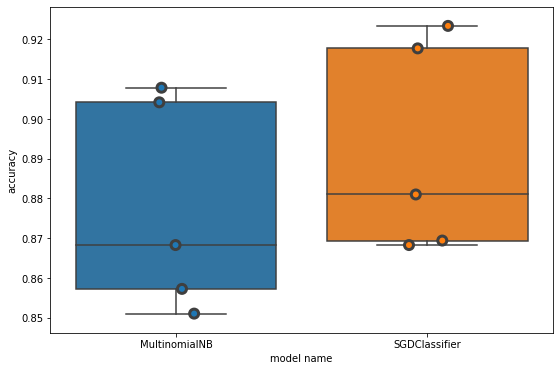

model name
MultinomialNB    0.877728
SGDClassifier    0.891973
Name: accuracy, dtype: float64

In [395]:
# resampled_train_question, resampled_train_question_labels
# Set up
models = [mnb, svm]
cross_validation = 5 # 5-fold cross validation
cv_tfidf = pd.DataFrame(index=range(cross_validation*len(models)))
entry = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model,resampled_train_question,resampled_train_question_labels,scoring='accuracy',cv=cross_validation)
    for fold_index, accuracy in enumerate(accuracies):
        entry.append((model_name,fold_index,accuracy))
    cv_tfidf=pd.DataFrame(entry, columns=['model name','fold_idx','accuracy'])

plt.figure(figsize=(9,6))
sns.boxplot(x='model name',y='accuracy',data=cv_tfidf)
sns.stripplot(x='model name',y='accuracy',data=cv_tfidf,
             size=9, jitter=True, edgecolor="gray",linewidth=3)

plt.show()
cv_tfidf.groupby('model name').accuracy.mean() # The accuracy mean of those models

### `Question | Model Selection | SVM vs Naive Bayes `

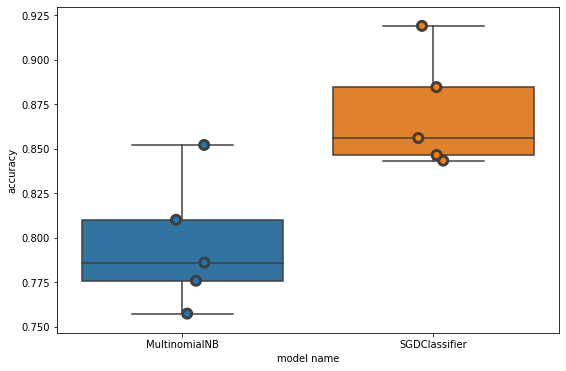

model name
MultinomialNB    0.796263
SGDClassifier    0.869911
Name: accuracy, dtype: float64

In [396]:
# resampled_train_answer, resampled_train_answer_labels
# Set up
models = [mnb, svm]
cross_validation = 5 # 5-fold cross validation
cv_tfidf = pd.DataFrame(index=range(cross_validation*len(models)))
entry = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model,resampled_train_answer,resampled_train_answer_labels,scoring='accuracy',cv=cross_validation)
    for fold_index, accuracy in enumerate(accuracies):
        entry.append((model_name,fold_index,accuracy))
    cv_tfidf=pd.DataFrame(entry, columns=['model name','fold_idx','accuracy'])

plt.figure(figsize=(9,6))
sns.boxplot(x='model name',y='accuracy',data=cv_tfidf)
sns.stripplot(x='model name',y='accuracy',data=cv_tfidf,
             size=9, jitter=True, edgecolor="gray",linewidth=3)

plt.show()
cv_tfidf.groupby('model name').accuracy.mean() # The accuracy mean of those models

## `Discussion`

- SVM did better than Naive Bayes on the training test for both Question and Answer classification
- The accuracy rate of **SVM** on question type classification is **89.298%** while accuracy rate of **Naive Bayes** is **88.008%** 
- The accuracy rate of **SVM** on answer type classification is **87.361%** while accuracy rate of **Naive Bayes** is **80.574%** 
- Therefore, **Support Vector Machine** perform **better**

## Step 7: Model Evaluation

### `Question`

In [43]:
# Question: Support Vector Machine | TFIDF
# resampled_train_question, resampled_train_question_labels
svmq_predictions = train_predict_evaluate_model(classifier=svm,
                                                 train_features=resampled_train_question,
                                                 train_labels=resampled_train_question_labels,
                                                 test_features=tfidf_test_question,
                                                 test_labels=test_question_id)

Accuracy: 0.50822
Precision: 0.48656
Recall: 0.50822
F1 Score: 0.49166


In [439]:
len(test_question_id)

1216

### `Confusion Matrix | Question`

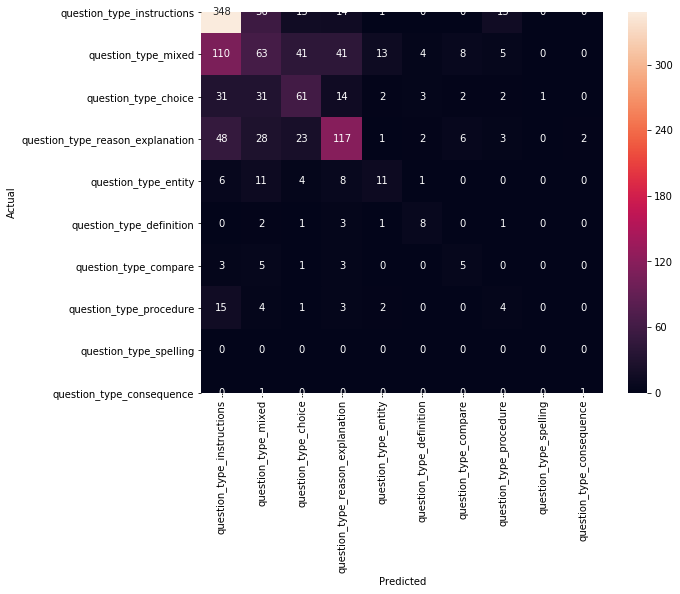

In [55]:
# create a confusion matrix
cm_q = metrics.confusion_matrix(test_question_id, svmq_predictions)

# Visualization the confusion matrix
plt.subplots(figsize=(9,7))
sns.heatmap(cm_q, annot=True, fmt="d",
            xticklabels=question_id_df.question_target_mix.values,
            yticklabels=question_id_df.question_target_mix.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [45]:
print(cm_q)

[[348  56  15  14   1   0   0  15   0   0]
 [110  63  41  41  13   4   8   5   0   0]
 [ 31  31  61  14   2   3   2   2   1   0]
 [ 48  28  23 117   1   2   6   3   0   2]
 [  6  11   4   8  11   1   0   0   0   0]
 [  0   2   1   3   1   8   0   1   0   0]
 [  3   5   1   3   0   0   5   0   0   0]
 [ 15   4   1   3   2   0   0   4   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0   0   0   1]]


In [46]:
test_question_id.unique()

array([0, 1, 4, 7, 3, 2, 6, 9, 5], dtype=int64)

In [47]:
new_q_df = question_id_df[question_id_df['question_target_mix']!='question_type_spelling']

In [48]:
# Metrics for each category
print(metrics.classification_report(test_question_id, svmq_predictions, target_names=question_id_df.question_target_mix.values))

                                  precision    recall  f1-score   support

      question_type_instructions       0.62      0.78      0.69       449
             question_type_mixed       0.31      0.22      0.26       285
            question_type_choice       0.41      0.41      0.41       147
question_type_reason_explanation       0.58      0.51      0.54       230
            question_type_entity       0.35      0.27      0.31        41
        question_type_definition       0.44      0.50      0.47        16
           question_type_compare       0.24      0.29      0.26        17
         question_type_procedure       0.13      0.14      0.14        29
          question_type_spelling       0.00      0.00      0.00         0
       question_type_consequence       0.33      0.50      0.40         2

                        accuracy                           0.51      1216
                       macro avg       0.34      0.36      0.35      1216
                    weighted avg    

C:\Users\Jennie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### `Answer`

In [49]:
# Answer: Support Vector Machine | TFIDF
# resampled_train_answer, resampled_train_answer_labels
svma_predictions = train_predict_evaluate_model(classifier=svm,
                                                 train_features=resampled_train_answer,
                                                 train_labels=resampled_train_answer_labels,
                                                 test_features=tfidf_test_answer,
                                                 test_labels=test_answer_id)

Accuracy: 0.61184
Precision: 0.56622
Recall: 0.61184
F1 Score: 0.55867


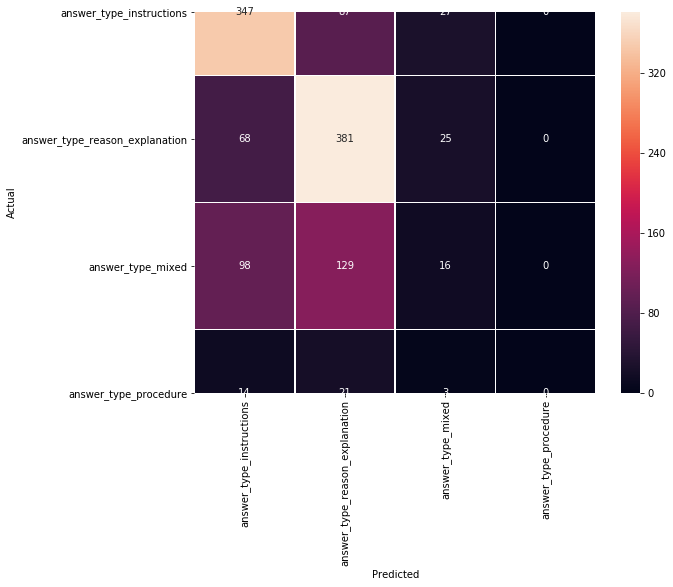

In [58]:
# create a confusion matrix
cm_a = metrics.confusion_matrix(test_answer_id, svma_predictions)

# Visualization the confusion matrix
fig, ax=plt.subplots(figsize=(9,7))
sns.heatmap(cm_a, annot=True,fmt="d",linewidths=.5, ax=ax,
           xticklabels=answer_id_df.answer_target_mix.values,
            yticklabels=answer_id_df.answer_target_mix.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [52]:
# Metrics for each category
print(metrics.classification_report(test_answer_id, svma_predictions, target_names=answer_id_df.answer_target_mix.values))

                                precision    recall  f1-score   support

      answer_type_instructions       0.66      0.75      0.70       461
answer_type_reason_explanation       0.62      0.80      0.70       474
             answer_type_mixed       0.23      0.07      0.10       243
         answer_type_procedure       0.00      0.00      0.00        38

                      accuracy                           0.61      1216
                     macro avg       0.38      0.41      0.38      1216
                  weighted avg       0.53      0.61      0.56      1216



C:\Users\Jennie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




## Step 9: Keras | Deep Learning with Tensor Flow | LSTM | TFIDF

However, Tensor Flow does not work every well in this case

In [452]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

In [453]:
encoder = LabelEncoder()

In [478]:
# Prepare feature for question
encoder.fit(train_question_id)
y_train = encoder.transform(resampled_train_question_labels)
y_test = encoder.transform(test_question_id)
y_train = encoder.transform(resampled_train_question_labels)
y_test = encoder.transform(test_question_id)

num_classes = np.max(y_train)+1
y_train = utils.to_categorical(y_train, num_classes) 
y_test = utils.to_categorical(y_test, num_classes)

x_train = resampled_train_question
x_test = tfidf_test_question

In [479]:
# Prepare feature for answer
encoder.fit(train_answer_id)
a_train = encoder.transform(resampled_train_answer_labels)
a_test = encoder.transform(test_answer_id)
a_train = encoder.transform(resampled_train_answer_labels)
a_test = encoder.transform(test_answer_id)

a_classes = np.max(a_train)+1
a_train = utils.to_categorical(a_train, a_classes) 
a_test =utils.to_categorical(a_test, a_classes) 

z_train = resampled_train_answer
z_test = tfidf_test_answer

## `Question | Deep Learning | TensorFlow`

In [461]:
print('x_train shape (question train):', x_train.shape)
print('x_test_shape (question test):',x_test.shape)
print('y_train_shape (question labels train):',y_train.shape)
print('y_test_shape (question labels test):',y_test.shape)

x_train shape (question train): (17690, 201506)
x_test_shape (question test): (1216, 201506)
y_train_shape (question labels train): (17690, 10)
y_test_shape (question labels test): (1216, 10)


In [462]:
# This model trains very quickly and 2 epochs are already more than enough - however we can still customize
# Training for more epochs will likely to lead to overfitting on the dataset
from sklearn.utils import class_weight
batch_size = 128
epochs = 2
# Adding class weight since our data are imbalance
class_weight = class_weight.compute_class_weight('balanced', np.unique(train_question_labels), train_question_labels)

# Build the model 
model = Sequential()
model.add(Dense(512, input_shape=(x_test.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [463]:
# model.fit trains the model
# The validation_split param tells Keras what % of our training data should be used in validation set
# The validation loss decreasing slowly when running this
# val_loss is no longer decreasing we stop training to prevent over fitting
history = model.fit(x_train, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   verbose=1,
                    class_weight=class_weight,
                   validation_split=0.2)

Train on 14152 samples, validate on 3538 samples
Epoch 1/2
14152/14152 [==============================] - 226s 16ms/step - loss: 1.0887 - accuracy: 0.7840 - val_loss: 4.9287 - val_accuracy: 0.0057
Epoch 2/2
14152/14152 [==============================] - 221s 16ms/step - loss: 0.3131 - accuracy: 0.9129 - val_loss: 3.9644 - val_accuracy: 0.0057


In [464]:
score = model.evaluate(x_test, y_test,
                      batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

1216/1216 [==============================] - 3s 2ms/step
Test score: 1.8918496934991134
Test accuracy: 0.4819079041481018


In [465]:
keras_prediction_q = model.predict_classes(x_test)

In [505]:
cm_keras_q = metrics.confusion_matrix(test_question_id, keras_prediction_q)

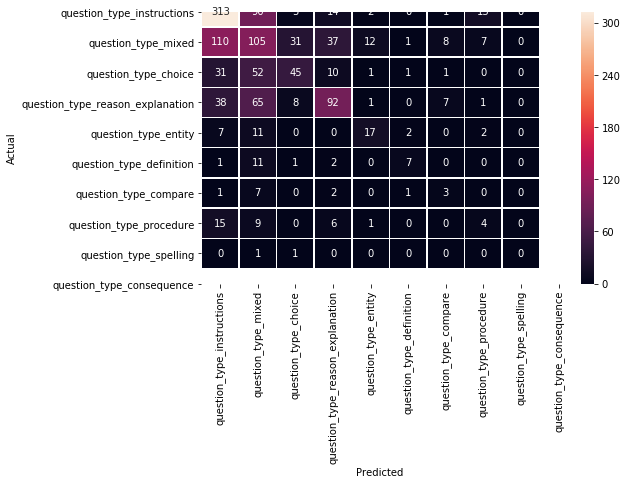

In [508]:
fig, ax=plt.subplots(figsize=(8,5))
sns.heatmap(cm_keras_q, annot=True,fmt="d",linewidths=.5, ax=ax,
           xticklabels=question_id_df.question_target_mix.values,
            yticklabels=question_id_df.question_target_mix.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [516]:
df_new = question_id_df[question_id_df.question_target_mix != 'question_type_spelling']
print(metrics.classification_report(test_question_id, keras_prediction_q, target_names=df_new.question_target_mix.values))

                                  precision    recall  f1-score   support

      question_type_instructions       0.61      0.71      0.65       440
             question_type_mixed       0.30      0.34      0.32       311
            question_type_choice       0.49      0.32      0.39       141
question_type_reason_explanation       0.56      0.43      0.49       212
            question_type_entity       0.50      0.44      0.47        39
        question_type_definition       0.58      0.32      0.41        22
           question_type_compare       0.15      0.21      0.18        14
         question_type_procedure       0.14      0.11      0.12        35
       question_type_consequence       0.00      0.00      0.00         2

                        accuracy                           0.48      1216
                       macro avg       0.37      0.32      0.34      1216
                    weighted avg       0.48      0.48      0.48      1216



In [514]:
question_id_df

,question_target_mix,question_id
0,question_type_instructions,0
1,question_type_mixed,1
3,question_type_choice,2
13,question_type_reason_explanation,3
15,question_type_entity,4
28,question_type_definition,5
39,question_type_compare,6
76,question_type_procedure,7
362,question_type_spelling,8
415,question_type_consequence,9


## `Answer | Deep Learning | Tensorflow`

In [481]:
print('a_train shape (answer train):', z_train.shape)
print('a_test_shape (answer test):',z_test.shape)
print('z_train_shape (answer labels train):',a_train.shape)
print('z_test_shape (answer labels test):',a_test.shape)

a_train shape (answer train): (7848, 317510)
a_test_shape (answer test): (1216, 317510)
z_train_shape (answer labels train): (7848, 4)
z_test_shape (answer labels test): (1216, 4)


In [497]:
# This model trains very quickly and 2 epochs are already more than enough - however we can still customize
# Training for more epochs will likely to lead to overfitting on the dataset
from sklearn.utils import class_weight
batch_size = 128
epochs = 2
# Adding class weight since our data are imbalance
class_weight = class_weight.compute_class_weight('balanced', np.unique(train_answer_labels), train_answer_labels)

# Build the model 
model_a = Sequential()
model_a.add(Dense(512, input_shape=(z_test.shape[1],)))
model_a.add(Activation('relu'))
model_a.add(Dropout(0.5))
model_a.add(Dense(a_classes))
model_a.add(Activation('softmax'))

model_a.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [498]:
history_a = model_a.fit(z_train, a_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   verbose=1,
                   class_weight=class_weight,
                   validation_split=0.2)

Train on 6278 samples, validate on 1570 samples
Epoch 1/2
6278/6278 [==============================] - 177s 28ms/step - loss: 1.1557 - accuracy: 0.6313 - val_loss: 1.4674 - val_accuracy: 0.3490
Epoch 2/2
6278/6278 [==============================] - 155s 25ms/step - loss: 0.4138 - accuracy: 0.9457 - val_loss: 0.2256 - val_accuracy: 0.9694


In [500]:
# Evaluate accuracy on testing set
score = model_a.evaluate(z_test, a_test,
                      batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

1216/1216 [==============================] - 5s 4ms/step
Test score: 1.021976677994979
Test accuracy: 0.6389802694320679


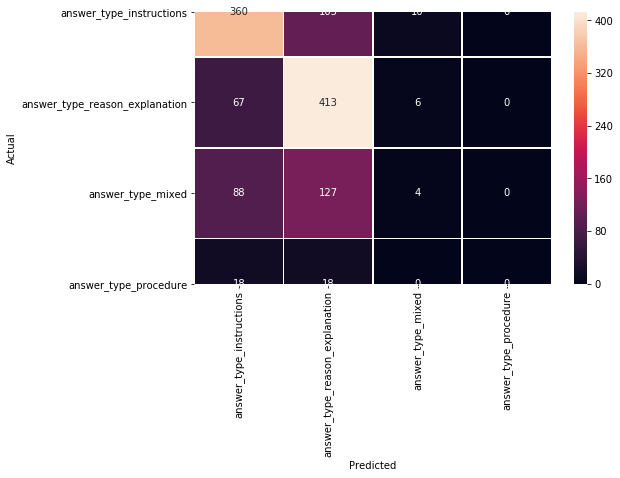

In [512]:
keras_prediction_a = model_a.predict_classes(z_test)
cm_keras_a = metrics.confusion_matrix(test_answer_id,keras_prediction_a)
fig, ax=plt.subplots(figsize=(8,5))
sns.heatmap(cm_keras_a, annot=True,fmt="d",linewidths=.5, ax=ax,
           xticklabels=answer_id_df.answer_target_mix.values,
            yticklabels=answer_id_df.answer_target_mix.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [519]:
print(metrics.classification_report(test_answer_id, keras_prediction_a, target_names=answer_id_df.answer_target_mix.values))

                                precision    recall  f1-score   support

      answer_type_instructions       0.68      0.76      0.71       475
answer_type_reason_explanation       0.62      0.85      0.72       486
             answer_type_mixed       0.20      0.02      0.03       219
         answer_type_procedure       0.00      0.00      0.00        36

                      accuracy                           0.64      1216
                     macro avg       0.37      0.41      0.37      1216
                  weighted avg       0.55      0.64      0.57      1216



## `Tokenization`

In [585]:

tokenize = text.Tokenizer(
                          lower=True,
                          filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                          split=' ',
                          char_level=False)

In [586]:
tokenize.fit_on_texts(train_answer) # only fit on train
x_train = tokenize.texts_to_matrix(train_answer)
x_test = tokenize.texts_to_matrix(test_answer)

In [587]:
encoder=LabelEncoder()
encoder.fit(train_answer_id)
y_train = encoder.transform(train_answer_id)
y_test = encoder.transform(test_answer_id)

In [588]:
num_classes=np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes) 
y_test = utils.to_categorical(y_test, num_classes)

In [589]:
print('x_train shape (question train):', x_train.shape)
print('x_test_shape (question test):',x_test.shape)
print('y_train_shape (question labels train):',y_train.shape)
print('y_test_shape (question labels test):',y_test.shape)

x_train shape (question train): (4863, 32921)
x_test_shape (question test): (1216, 32921)
y_train_shape (question labels train): (4863, 4)
y_test_shape (question labels test): (1216, 4)


In [590]:
batch_size = 58
epochs = 5

# Build the model 
model2 = Sequential()
model2.add(Dense(512, input_shape=(x_train.shape[1],)))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(num_classes))
model2.add(Activation('softmax'))

model2.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [591]:
history = model2.fit(x_train, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   verbose=1,
                   validation_split=0.1)

Train on 4376 samples, validate on 487 samples
Epoch 1/5
4376/4376 [==============================] - 18s 4ms/step - loss: 1.0644 - accuracy: 0.5948 - val_loss: 0.9515 - val_accuracy: 0.6386
Epoch 2/5
4376/4376 [==============================] - 19s 4ms/step - loss: 0.5951 - accuracy: 0.7973 - val_loss: 1.0222 - val_accuracy: 0.6119
Epoch 3/5
4376/4376 [==============================] - 18s 4ms/step - loss: 0.2766 - accuracy: 0.9250 - val_loss: 1.1175 - val_accuracy: 0.5955
Epoch 4/5
4376/4376 [==============================] - 25s 6ms/step - loss: 0.1115 - accuracy: 0.9835 - val_loss: 1.2674 - val_accuracy: 0.6057
Epoch 5/5
4376/4376 [==============================] - 19s 4ms/step - loss: 0.0487 - accuracy: 0.9973 - val_loss: 1.4043 - val_accuracy: 0.6016


In [592]:
score = model2.evaluate(x_test, y_test,
                      batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

1216/1216 [==============================] - 1s 623us/step
Test score: 1.574317210402928
Test accuracy: 0.5904605388641357


## Conclusion

- **LSTM** did the best with **TFIDF** when classifying answer type
- **SVM** did the best with **TFIDF** when classifying question type

There are multiple limitation in our project. First of all, our data set are extremly imbalanced between classes, which is a big challenge when dealing with multi-classification problem. Secondly, we don't have the dictionary for TYPE classification. For instance, sentiment would have dictionary for the topic. 

For model improvement in the future, we might try part of speech as another feature to improve the model

## Appendix

This section contains some information about the Bayes Net that we haven't try yet

# Bayes Net
- **Did not perform as well as SVM**

### `Question`

In [152]:
# Bayes Net | Question | TFIDF | Not over sampling
mnb_bow_predictions = train_predict_evaluate_model(classifier=mnb,
                                                 train_features=tfidf_train_question,
                                                 train_labels=train_question_labels,
                                                 test_features=tfidf_test_question,
                                                 test_labels=test_question_labels)

Accuracy: 0.4227
Precision: 0.51873
Recall: 0.4227
F1 Score: 0.32633


In [156]:
mnb_bow_predictions = train_predict_evaluate_model(classifier=mnb,
                                                 train_features=resampled_train_question,
                                                 train_labels=resampled_train_question_labels,
                                                 test_features=tfidf_test_question,
                                                 test_labels=test_question_labels)

Accuracy: 0.47039
Precision: 0.47353
Recall: 0.47039
F1 Score: 0.46707


### ` Answer`

In [153]:
# Bayes Net | Answer | TFIDF | Not over sampling
mnb_bow_predictions = train_predict_evaluate_model(classifier=mnb,
                                                 train_features=tfidf_train_answer,
                                                 train_labels=train_answer_labels,
                                                 test_features=tfidf_test_answer,
                                                 test_labels=test_answer_labels)

Accuracy: 0.60855
Precision: 0.71635
Recall: 0.60855
F1 Score: 0.52908


### Apply Over-sampling Features 

With BayesNet the accuracy rate decreases

In [154]:
# Answer: Support Vector Machine | TFIDF
mnb_bow_predictions = train_predict_evaluate_model(classifier=mnb,
                                                 train_features=resampled_train_answer,
                                                 train_labels=resampled_train_answer_labels,
                                                 test_features=tfidf_test_answer,
                                                 test_labels=test_answer_labels)

Accuracy: 0.55592
Precision: 0.56986
Recall: 0.55592
F1 Score: 0.55414


### `Question`

### Over Sampling

### `Answer`

In [244]:
# Neural network | Answer | TFIDF | Not over sampling
dnns_bow_predictions = train_predict_evaluate_model(classifier=dnns_classifier,
                                                 train_features=tfidf_train_answer,
                                                 train_labels=train_answer_labels,
                                                 test_features=tfidf_test_answer,
                                                 test_labels=test_answer_labels)

Accuracy: 0.62582
Precision: 0.59449
Recall: 0.62582
F1 Score: 0.5859


### Over Sampling

In [247]:
# Neural Network | Answer | TFIDF | Not over sampling
dnns_bow_predictions = train_predict_evaluate_model(classifier=dnns_classifier,
                                                 train_features=resampled_train_answer,
                                                 train_labels=resampled_train_answer_labels,
                                                 test_features=tfidf_test_answer,
                                                 test_labels=test_answer_labels)

Accuracy: 0.62336
Precision: 0.59512
Recall: 0.62336
F1 Score: 0.58716
